<a href="https://colab.research.google.com/github/iyoob-utexas/ds4e/blob/main/notebooks/n8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

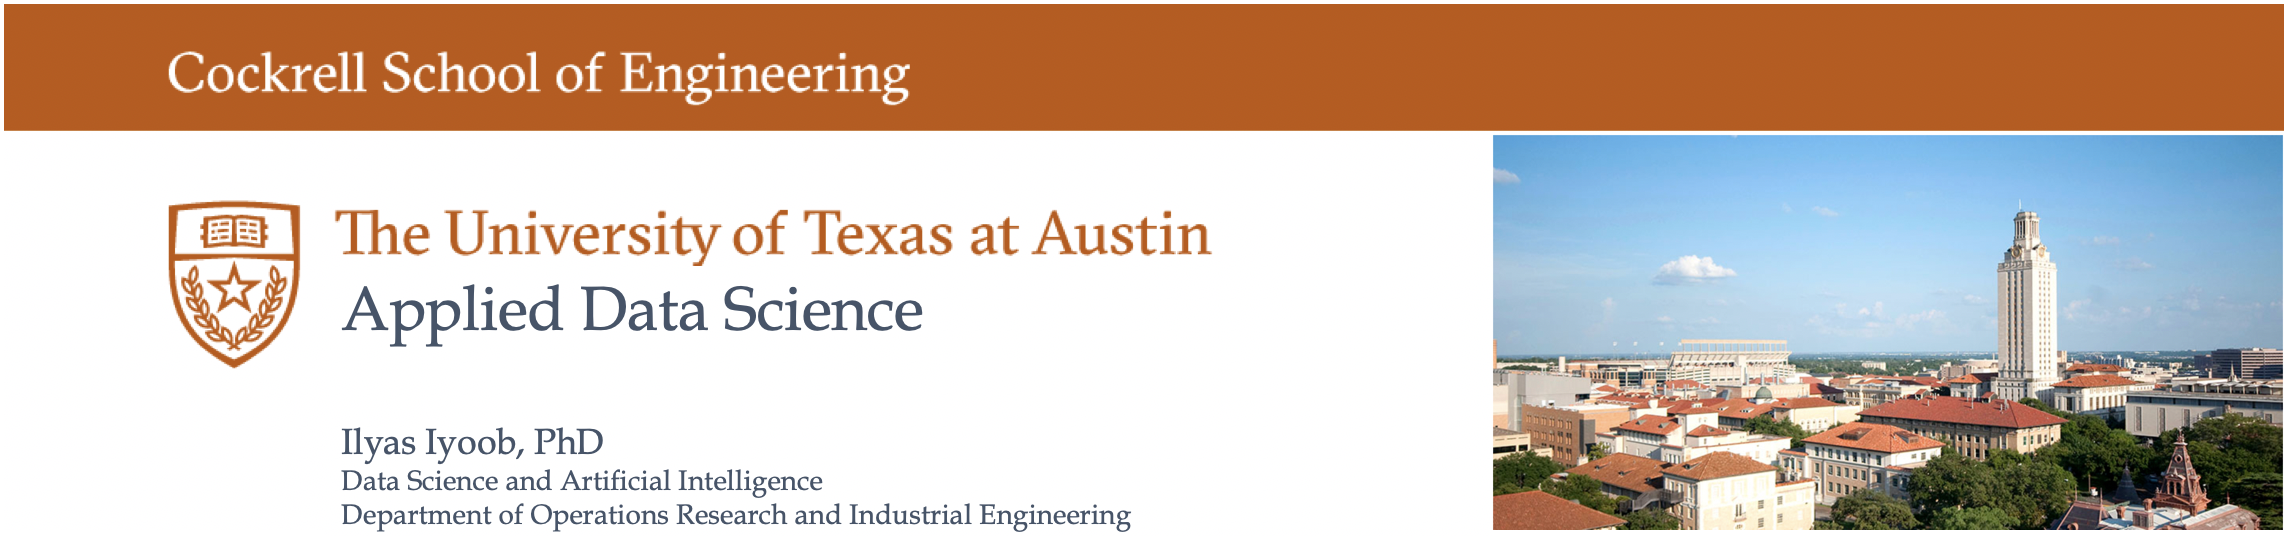

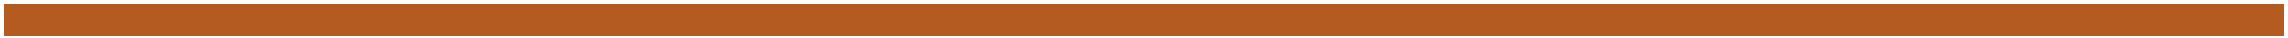

## <font color='#475468'> Preference Recommendations:</font> 
### <font color='#475468'> Can you recommend movies that users may like?</font> 

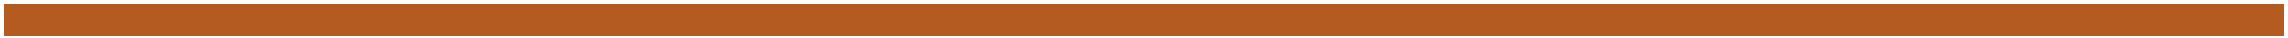

## Initialize

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Movie metadata
dfMvs = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/movies/movies_metadata_clean_small.csv')

# User ratings for each movie
dfMvsRtg = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/movies/movies_ratings_small.csv')

## Build Recommendations

WHITEBOARD >>

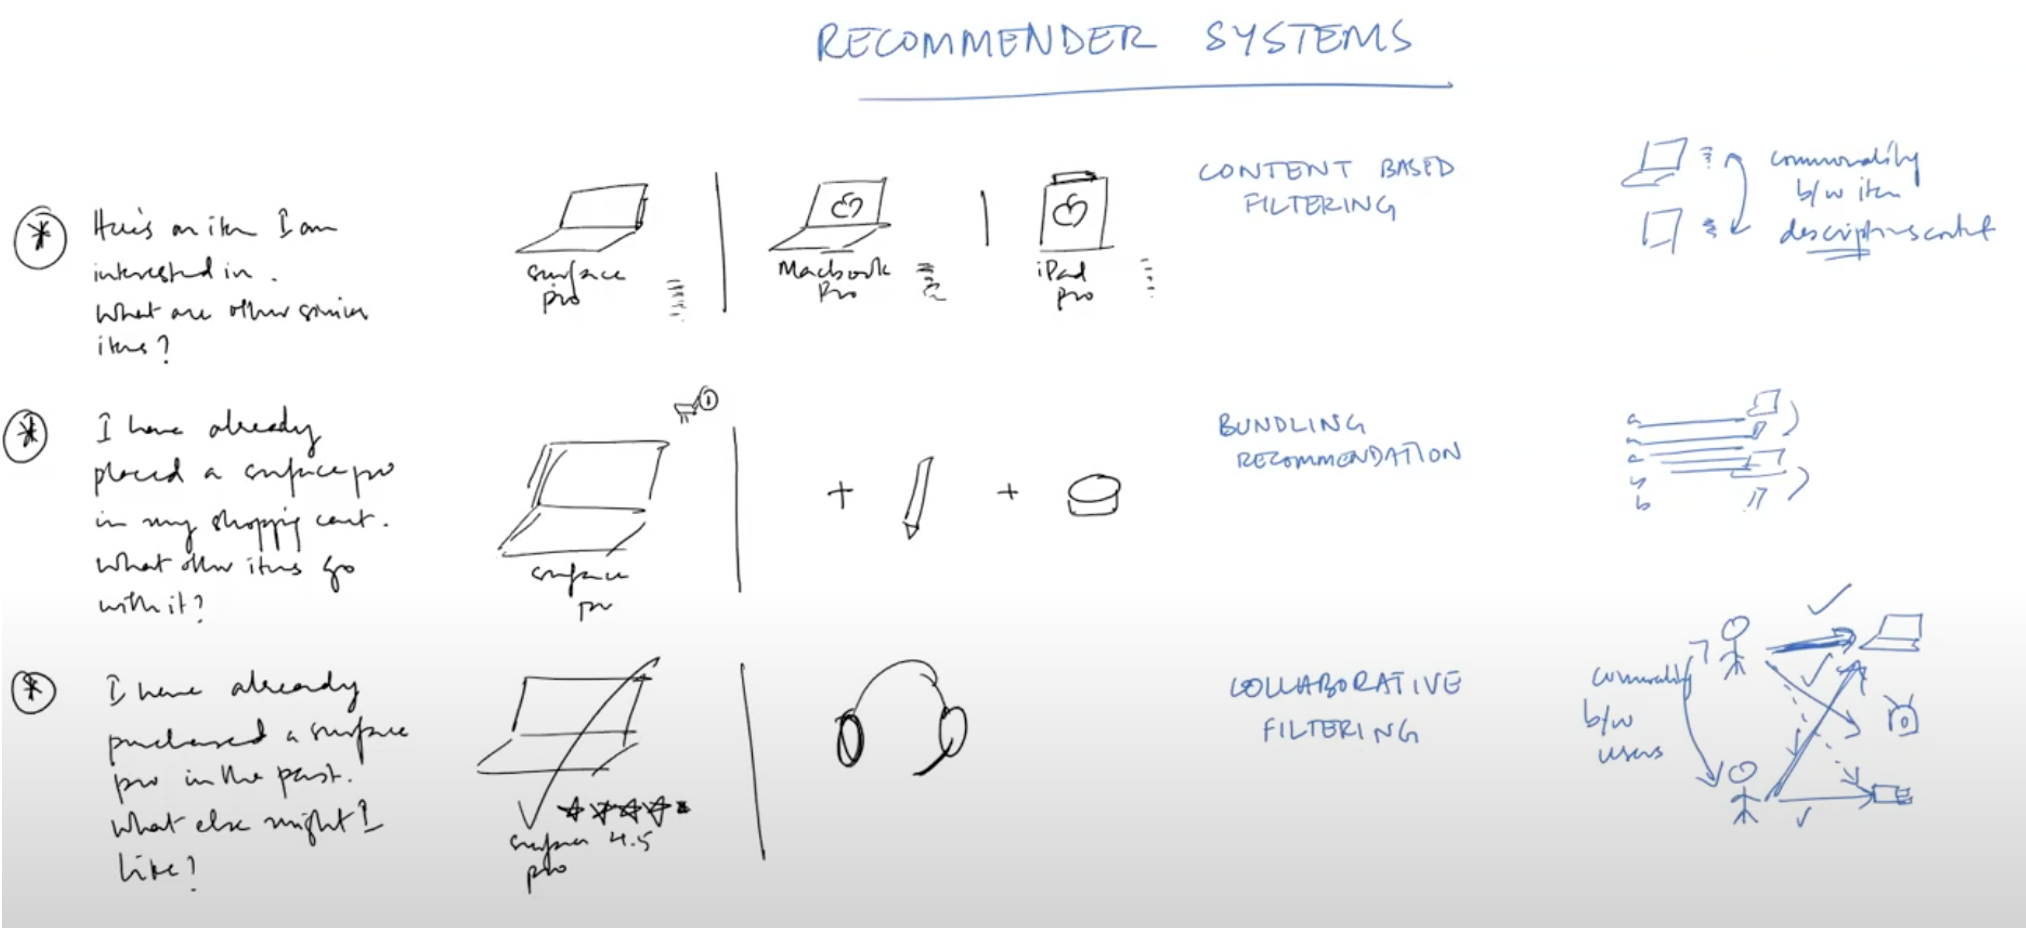

#### Content Based filtering

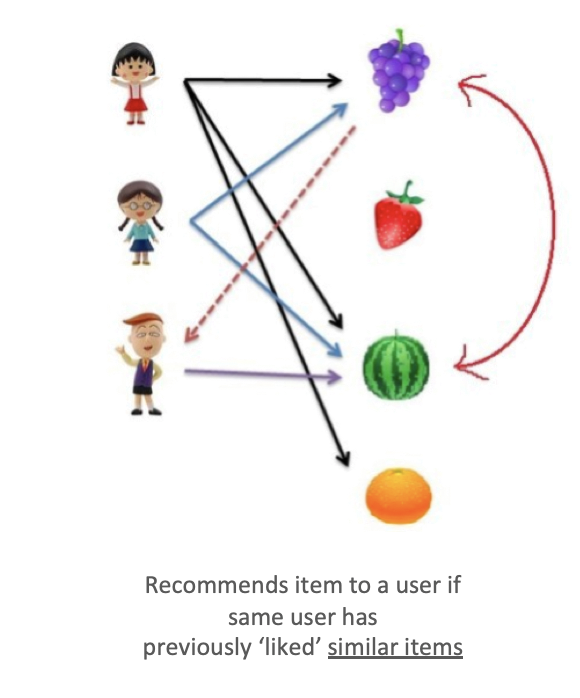

#### Collaborative filtering

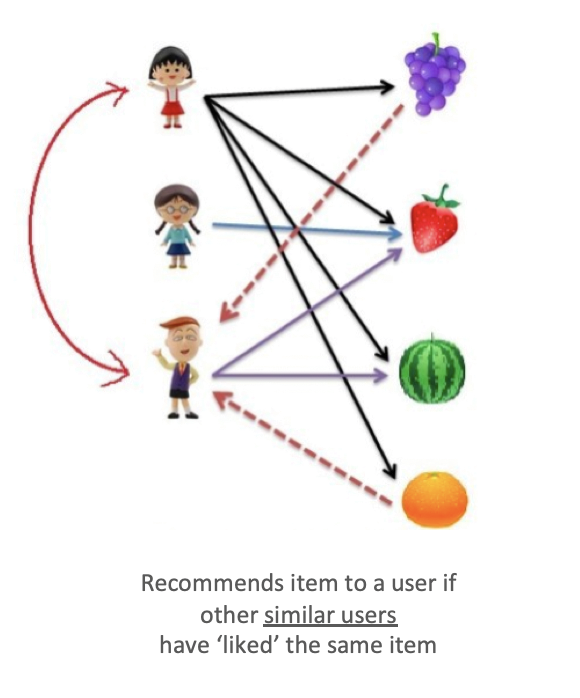

<< WHITEBOARD

Let us first try to build a recommender using movie content such as descriptions and taglines, also known as **Content Based Filtering**

### 1. Content Based Filtering

The idea here is to determine how similar the descriptions are based on the terms used in the descriptions - while ignoring commonly used words.  Then recommend other items with similar descriptions.  In order to do this, **TF-IDF Vectorization** is used.

WHITEBOARD >>

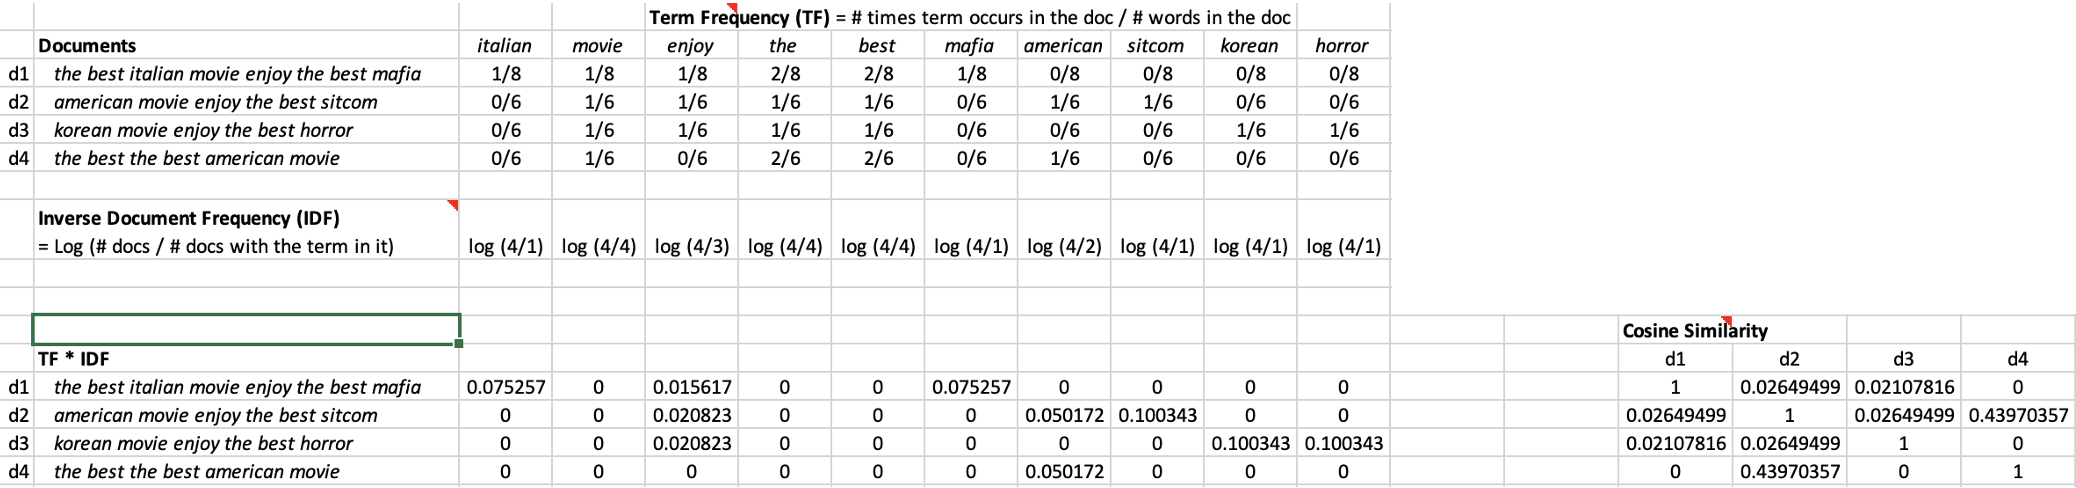

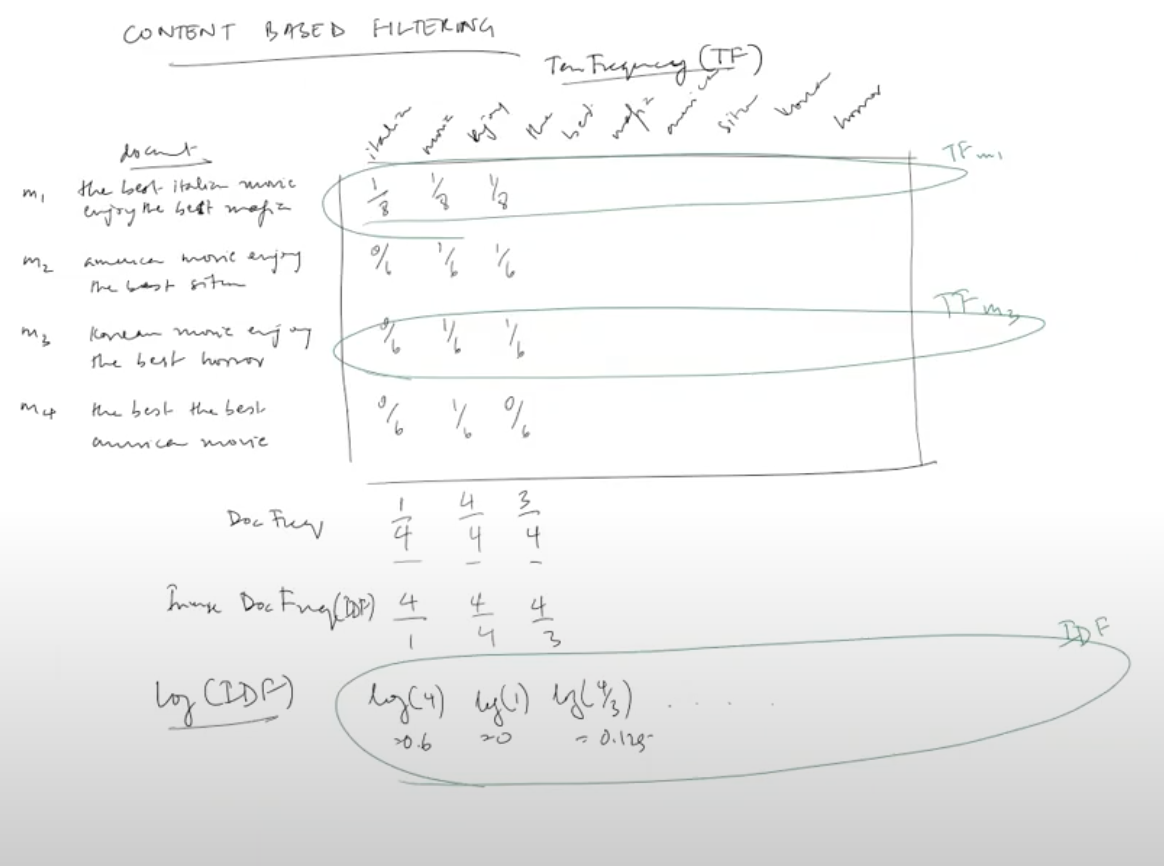

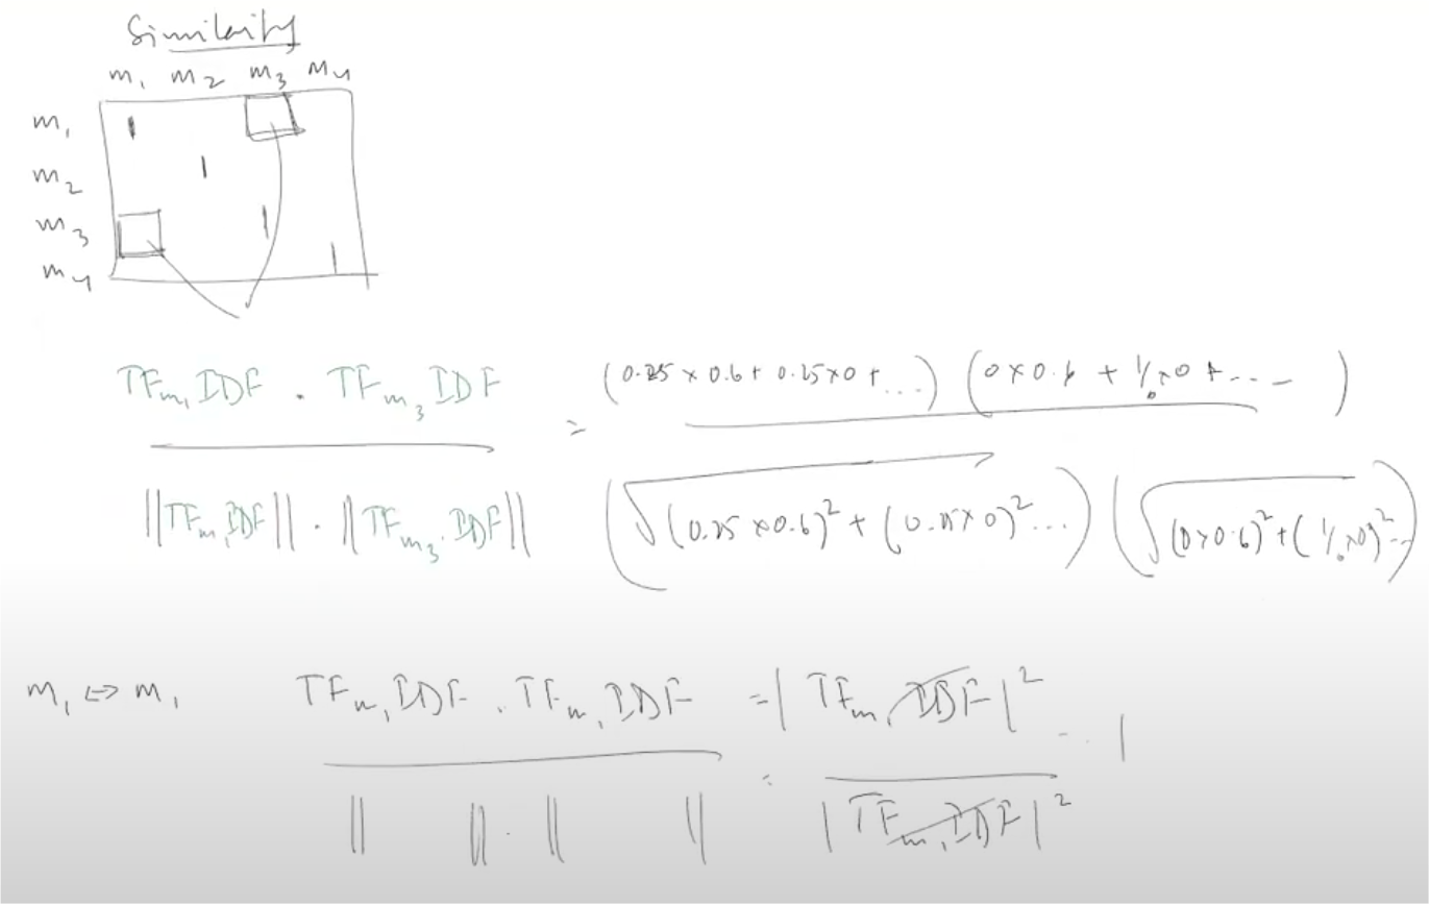

<< WHITEBOARD

#### Prepare data

In [15]:
dfMvs.head()

adult  ... vote_count
0  False  ...         58
1  False  ...          1
2  False  ...         12
3  False  ...          1
4  False  ...          1

[5 rows x 24 columns]

In [16]:
dfMvs.shape

(24009, 24)

In [17]:
# Remove duplicates
dfMvs.drop_duplicates(subset ='title', keep = 'first', inplace = True)
dfMvs.shape

(23091, 24)

In [18]:
# Prepare the description column

dfMvs['tagline'] = dfMvs['tagline'].fillna('')
dfMvs['description'] = dfMvs['overview'] + dfMvs['tagline']
dfMvs['description'] = dfMvs['description'].fillna('')

#### Build Model

In [19]:
# Generate a matrix of common terms that show up in each movie

from sklearn.feature_extraction.text import TfidfVectorizer
mdlTfvMvs = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = mdlTfvMvs.fit_transform(dfMvs['description'])
tfidf_matrix.shape

(23091, 618866)

The similarity between any two movies (x) and (y) is defined as the **Cosine Similarity**:
cosine(x,y)=x.y⊺||x||.||y|| 

Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score.

In [20]:
# Calculate cosine similarity between each pair of movies as a function of the similarity of the common terms

from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim.shape

(23091, 23091)

#### Predict

In [21]:
# Prepare recommendation function (build code from scratch and then package as function for ease of understanding)

titles = dfMvs['title']
indices = pd.Series(dfMvs.index, index=dfMvs['title'])

def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [27]:
get_recommendations('Kidnap').head(10)

20143                              Dear Frankie
18311                                     Karla
4740                                 Fort Bliss
18851                              The Business
2234                           Food and Shelter
327                     Vengeance: A Love Story
19871                   It's All Gone Pete Tong
22529                  Riding in Cars with Boys
9430     Monster High: Escape from Skull Shores
3916                              Away and Back
Name: title, dtype: object

In [23]:
get_recommendations('Bad Boys for Life').head(10)

20964                                   Bad Boys II
23575    Anne Of Green Gables: The Continuing Story
1756                     My Big Fat Greek Wedding 2
11389                              Night Catches Us
12348                                   In My Sleep
4996                              My Man is a Loser
15395                                       Redbelt
12860                                         The U
17596                                      Fay Grim
20888                             Stitch! The Movie
Name: title, dtype: object

These recommendations suggest movies that are close in name and description. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who s/he is.  This is a good way of providing recommendations especially when no further data is available.  

What if we also have data on personal tastes?  Can we make recommendations that capture these tastes and recommend movies that are more personalized?  For this, we use a technique called **Collaborative Filtering** which is based on the idea that users similar to me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

utexas_ds_orie_divider_gray.png

### 2. Collaborative Filtering

The idea here is that a user x movie matrix is decomposed into a product of user x concept . concept x concept . concept x movie matrices.  These can then be used to derive similarities between users.  This process is known as **Singular Value Decomposition**.

WHITEBOARD >>

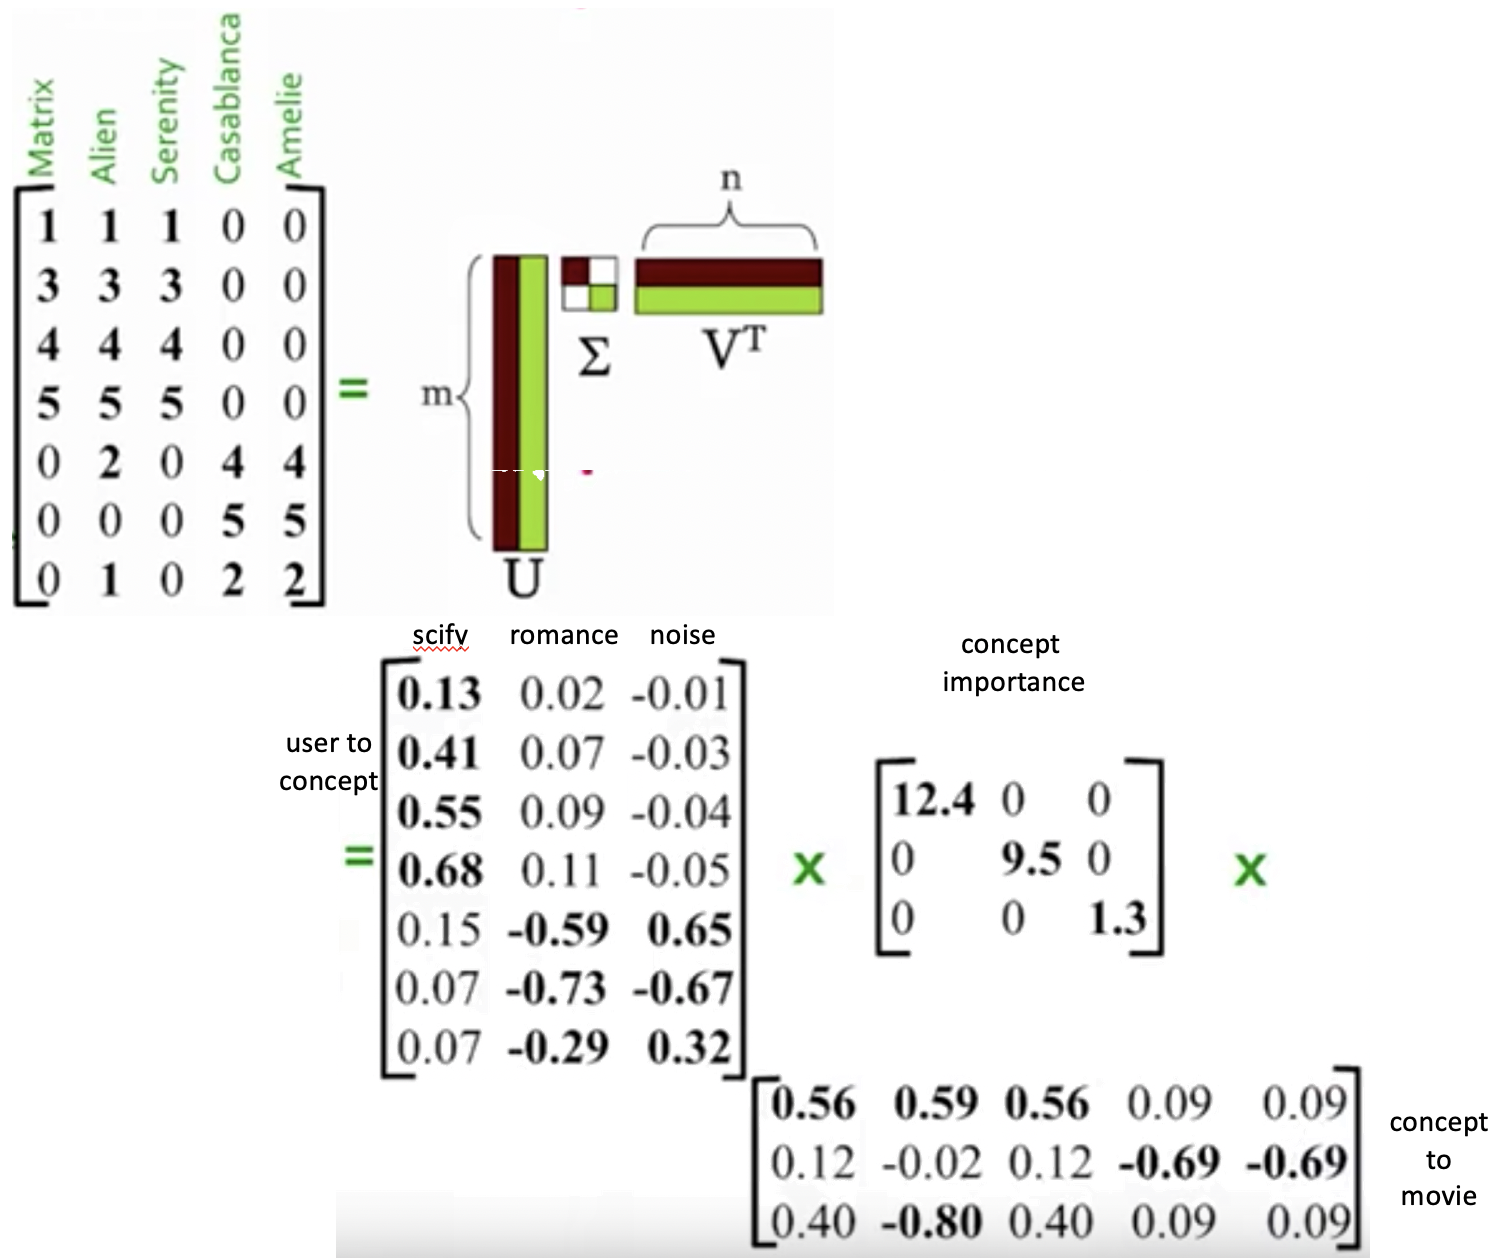

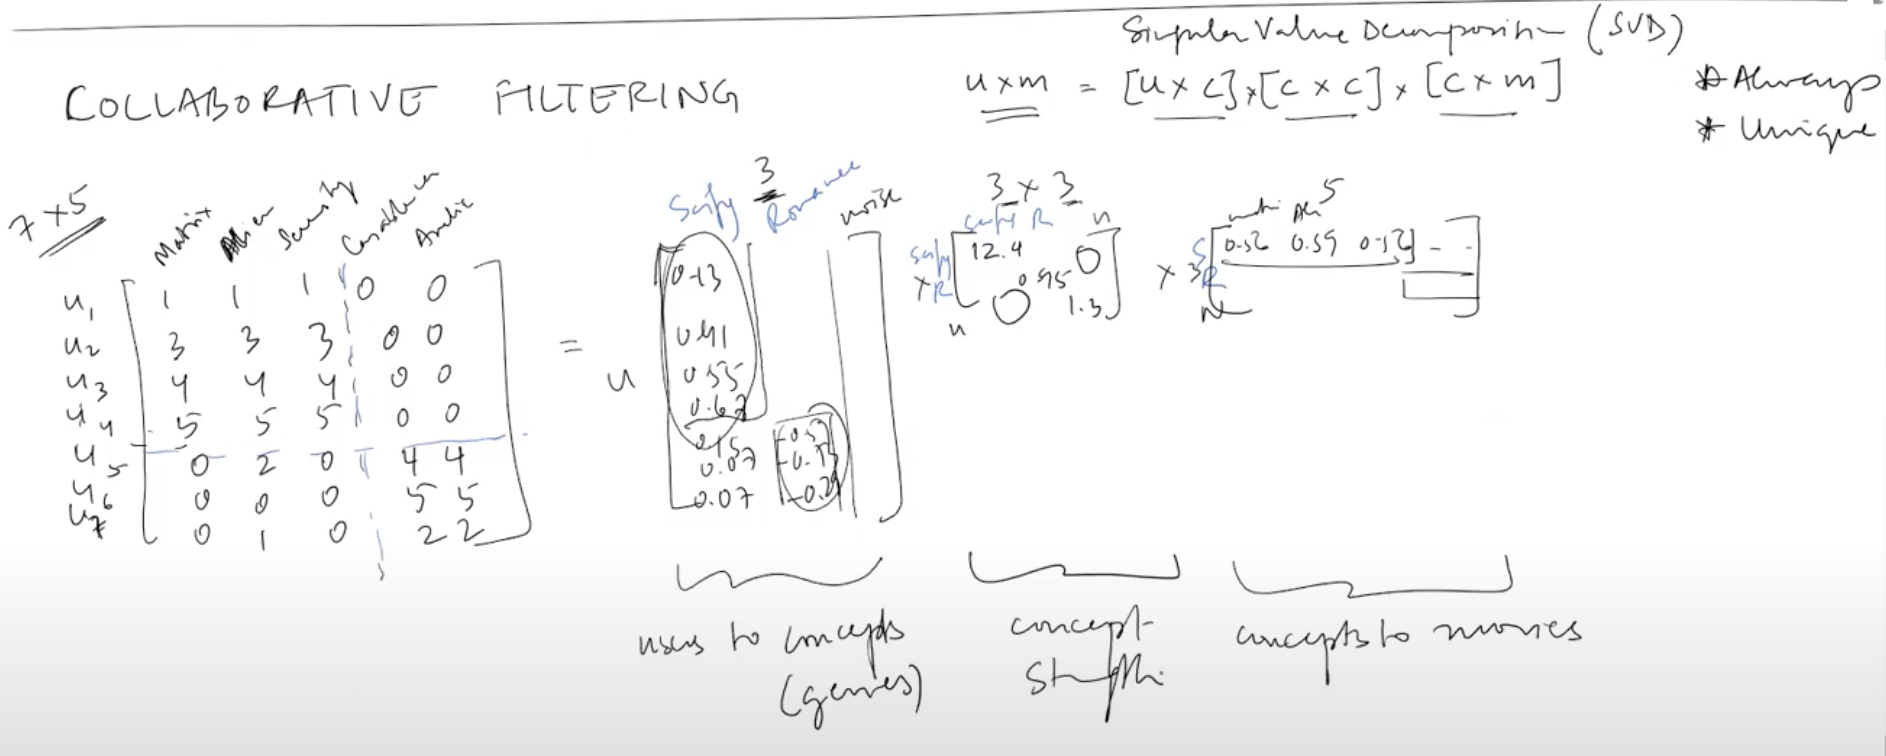

<< WHITEBOARD

#### Prepare data

In [28]:
dfMvsRtg.head(10)

userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205
5       1     1263     2.0  1260759151
6       1     1287     2.0  1260759187
7       1     1293     2.0  1260759148
8       1     1339     3.5  1260759125
9       1     1343     2.0  1260759131

#### Build Model

In [30]:
# Prepare data into Surprise library format

!pip3 install scikit-surprise #or !conda install -c conda-forge scikit-surprise
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(0,5))
X = Dataset.load_from_df(dfMvsRtg[['userId', 'movieId', 'rating']], reader)
X_train, X_test = train_test_split(X, test_size=.25)

     |████████████████████████████████| 11.8 MB 1.2 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1623221 sha256=b22dacdfa648dd52f988d6aeec8984617e453cc75dc604649930afbe9a143b37
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [31]:
# Define SVD model

from surprise import SVD

mdlSvdMvsRtg = SVD()

In [32]:
# Fit SVD model

mdlSvdMvsRtg.fit(X_train)
test_pred = mdlSvdMvsRtg.test(X_test)

In [33]:
# Evalute SVD accuracy

from surprise import accuracy

accuracy.rmse(test_pred)

RMSE: 0.8983


0.8983331481657552

In [34]:
# Tune hyperparameters

from surprise.model_selection import GridSearchCV

param_grid = {'n_epochs': [5, 10, 15], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(X)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.90918020440815
{'n_epochs': 15, 'lr_all': 0.005, 'reg_all': 0.4}


In [35]:
# Cross-validate

from surprise.model_selection import cross_validate

cross_validate(mdlSvdMvsRtg, X, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8950  0.8983  0.8965  0.9042  0.8903  0.8969  0.0045  
MAE (testset)     0.6901  0.6900  0.6904  0.6967  0.6864  0.6907  0.0033  
Fit time          4.77    4.73    4.74    4.75    4.77    4.75    0.02    
Test time         0.15    0.15    0.27    0.15    0.27    0.20    0.06    


{'fit_time': (4.768057584762573,
  4.731797456741333,
  4.739300012588501,
  4.754231214523315,
  4.769356727600098),
 'test_mae': array([0.69011485, 0.68996555, 0.69042606, 0.69665612, 0.68640468]),
 'test_rmse': array([0.89502716, 0.89833143, 0.89651727, 0.90423092, 0.89026363]),
 'test_time': (0.1537783145904541,
  0.14821195602416992,
  0.26720523834228516,
  0.15477705001831055,
  0.26959800720214844)}

Let us now use the trained model to arrive at predictions.

#### Predict

Let's first see which movies user # 1 has already viewed.

In [36]:
dfMvsRtg[dfMvsRtg['userId'] == 1]

userId  movieId  rating   timestamp
0        1       31     2.5  1260759144
1        1     1029     3.0  1260759179
2        1     1061     3.0  1260759182
3        1     1129     2.0  1260759185
4        1     1172     4.0  1260759205
5        1     1263     2.0  1260759151
6        1     1287     2.0  1260759187
7        1     1293     2.0  1260759148
8        1     1339     3.5  1260759125
9        1     1343     2.0  1260759131
10       1     1371     2.5  1260759135
11       1     1405     1.0  1260759203
12       1     1953     4.0  1260759191
13       1     2105     4.0  1260759139
14       1     2150     3.0  1260759194
15       1     2193     2.0  1260759198
16       1     2294     2.0  1260759108
17       1     2455     2.5  1260759113
18       1     2968     1.0  1260759200
19       1     3671     3.0  1260759117

Now, let's predict what rating user # 1 would give to movie # 302 (since he/she hasn't seen it yet)

In [37]:
mdlSvdMvsRtg.predict(1, 302)

Prediction(uid=1, iid=302, r_ui=None, est=2.879218699574591, details={'was_impossible': False})

One startling feature of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

An extension to this could be to create a hybrid model that uses content filtering in the initial phase when user preferences are not available, and then gradually shift to a collaborative filtering model blended with some content filtering.

## Takeaways

* Introduced content-based filtering to recommend items based on their descriptions using *TF-IDF Vectorization* 
* In the event that user preference data is available, collaborative filtering is leveraged to recommend items based on other similar users using *Singular Value Decomposition*

WHITEBOARD >>

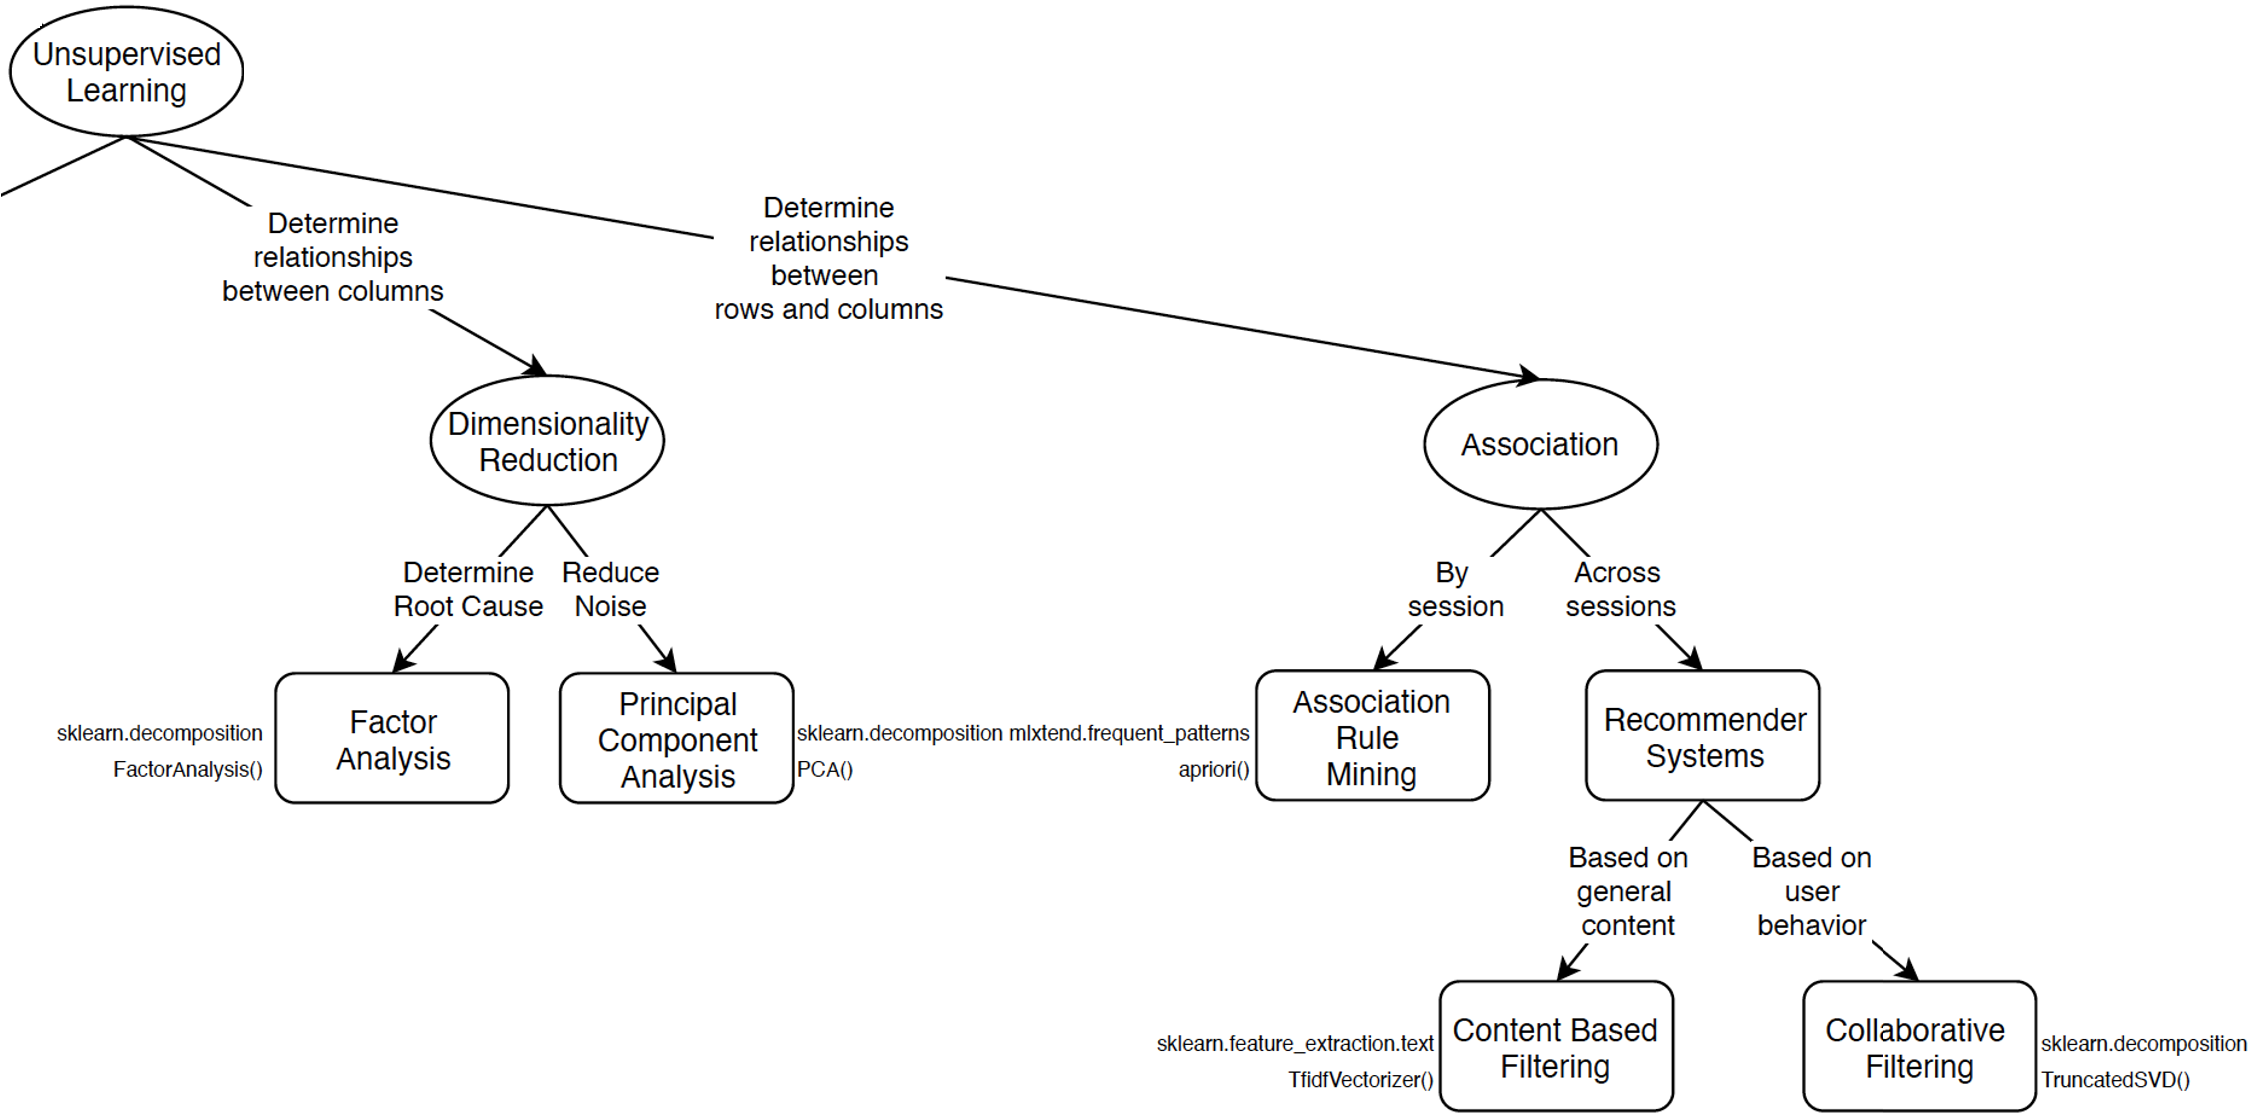

<< WHITEBOARD

utexas_ds_orie_divider_gray.png